In [1]:
# clahe main code
import numpy as np
import imageio
import matplotlib.pyplot as plt
from skimage import io
import time
from os import listdir
from os.path import isfile, join
#INTERPOLATION FUNCTION
def interpolate(subBin,LU,RU,LB,RB,subX,subY):
    subImage = np.zeros(subBin.shape)
    num = subX*subY
    for i in range(subX):
        inverseI = subX-i
        for j in range(subY):
            inverseJ = subY-j
            val = subBin[i,j].astype(int)
            subImage[i,j] = np.floor((inverseI*(inverseJ*LU[val] + j*RU[val])+ i*(inverseJ*LB[val] + j*RB[val]))/float(num))
    return subImage

#CLAHE FUNCTION
#ALL UTILITY FUNCTIONS COMBINED INTO ONE FUNCTION
def clahe(img,clipLimit=8,nrBins=128,nrX=0,nrY=0):
    '''img - Input image
       clipLimit - Normalized clipLimit. Higher value gives more contrast
       nrBins - Number of graylevel bins for histogram("dynamic range")
       nrX - Number of contextial regions in X direction
       nrY - Number of Contextial regions in Y direction'''
    h,w = img.shape
    if clipLimit==1:
        return
    nrBins = max(nrBins,128)
    if nrX==0:
        #Taking dimensions of each contextial region to be a square of 32X32
        xsz = 32
        ysz = 32
        nrX = np.ceil(h/xsz).astype(int)#240
        #Excess number of pixels to get an integer value of nrX and nrY
        excX= int(xsz*(nrX-h/xsz))
        nrY = np.ceil(w/ysz).astype(int)#320
        excY= int(ysz*(nrY-w/ysz))
        #Pad that number of pixels to the image
        if excX!=0:
            img = np.append(img,np.zeros((excX,img.shape[1])).astype(int),axis=0)
        if excY!=0:
            img = np.append(img,np.zeros((img.shape[0],excY)).astype(int),axis=1)
    else:
        xsz = round(h/nrX)
        ysz = round(w/nrY)
    
    nrPixels = xsz*ysz
    xsz2 = round(xsz/2)
    ysz2 = round(ysz/2)
    claheimg = np.zeros(img.shape)
    
    if clipLimit > 0:
        clipLimit = max(1,clipLimit*xsz*ysz/nrBins)
    else:
        clipLimit = 50
    
    #makeLUT
    print("...Make the LUT...")
    minVal = 0 #np.min(img)
    maxVal = 255 #np.max(img)
    
    #maxVal1 = maxVal + np.maximum(np.array([0]),minVal) - minVal
    #minVal1 = np.maximum(np.array([0]),minVal)
    
    binSz = np.floor(1+(maxVal-minVal)/float(nrBins))
    LUT = np.floor((np.arange(minVal,maxVal+1)-minVal)/float(binSz))
    
    #BACK TO CLAHE
    bins = LUT[img]
    print(bins.shape)
    #makeHistogram
    print("...Making the Histogram...")
    hist = np.zeros((nrX,nrY,nrBins))
    print(nrX,nrY,hist.shape)
    for i in range(nrX):
        for j in range(nrY):
            bin_ = bins[i*xsz:(i+1)*xsz,j*ysz:(j+1)*ysz].astype(int)
            for i1 in range(xsz):
                for j1 in range(ysz):
                    hist[i,j,bin_[i1,j1]]+=1
    
    #clipHistogram
    print("...Clipping the Histogram...")
    if clipLimit>0:
        for i in range(nrX):
            for j in range(nrY):
                nrExcess = 0
                for nr in range(nrBins):
                    excess = hist[i,j,nr] - clipLimit
                    if excess>0:
                        nrExcess += excess
                
                binIncr = nrExcess/nrBins
                upper = clipLimit - binIncr
                for nr in range(nrBins):
                    if hist[i,j,nr] > clipLimit:
                        hist[i,j,nr] = clipLimit
                    else:
                        if hist[i,j,nr]>upper:
                            nrExcess += upper - hist[i,j,nr]
                            hist[i,j,nr] = clipLimit
                        else:
                            nrExcess -= binIncr
                            hist[i,j,nr] += binIncr
                
                if nrExcess > 0:
                    stepSz = max(1,np.floor(1+nrExcess/nrBins))
                    for nr in range(nrBins):
                        nrExcess -= stepSz
                        hist[i,j,nr] += stepSz
                        if nrExcess < 1:
                            break
    
    #mapHistogram
    print("...Mapping the Histogram...")
    map_ = np.zeros((nrX,nrY,nrBins))
    #print(map_.shape)
    scale = (maxVal - minVal)/float(nrPixels)
    for i in range(nrX):
        for j in range(nrY):
            sum_ = 0
            for nr in range(nrBins):
                sum_ += hist[i,j,nr]
                map_[i,j,nr] = np.floor(min(minVal+sum_*scale,maxVal))
    
    #BACK TO CLAHE
    #INTERPOLATION
    print("...interpolation...")
    xI = 0
    for i in range(nrX+1):
        if i==0:
            subX = int(xsz/2)
            xU = 0
            xB = 0
        elif i==nrX:
            subX = int(xsz/2)
            xU = nrX-1
            xB = nrX-1
        else:
            subX = xsz
            xU = i-1
            xB = i
        
        yI = 0
        for j in range(nrY+1):
            if j==0:
                subY = int(ysz/2)
                yL = 0
                yR = 0
            elif j==nrY:
                subY = int(ysz/2)
                yL = nrY-1
                yR = nrY-1
            else:
                subY = ysz
                yL = j-1
                yR = j
            UL = map_[xU,yL,:]
            UR = map_[xU,yR,:]
            BL = map_[xB,yL,:]
            BR = map_[xB,yR,:]
            #print("CLAHE vals...")
            subBin = bins[xI:xI+subX,yI:yI+subY]
            #print("clahe subBin shape: ",subBin.shape)
            subImage = interpolate(subBin,UL,UR,BL,BR,subX,subY)
            claheimg[xI:xI+subX,yI:yI+subY] = subImage
            yI += subY
        xI += subX
    
    if excX==0 and excY!=0:
        return claheimg[:,:-excY]
    elif excX!=0 and excY==0:
        return claheimg[:-excX,:]
    elif excX!=0 and excY!=0:
        return claheimg[:-excX,:-excY]
    else:
        return claheimg

In [3]:
# multiprocessing on clahe with 2 cores
import multiprocessing
from clahe_1 import *

def main():
    files = [imageio.imread(join("Pict20", f))[:,:,0] for f in listdir("Pict20") if isfile(join("Pict20", f))]
    
    pool = multiprocessing.Pool(processes=2)
    start_time= time.time()
    clahe_img = pool.map(clahe, files)
    print(time.time() - start_time)
if __name__ == '__main__':
    main()

15.304189920425415


In [6]:
# multiprocessing on clahe with 4 cores
import multiprocessing
from clahe_1 import *

def main():
    files = [imageio.imread(join("Pict20", f))[:,:,0] for f in listdir("Pict20") if isfile(join("Pict20", f))]
    
    pool = multiprocessing.Pool(processes=4)
    start_time= time.time()
    clahe_img = pool.map(clahe, files)
    print(time.time() - start_time)
if __name__ == '__main__':
    main()

10.314742088317871


In [7]:
# multiprocessing on clahe with 6 cores
import multiprocessing
from clahe_1 import *

def main():
    files = [imageio.imread(join("Pict20", f))[:,:,0] for f in listdir("Pict20") if isfile(join("Pict20", f))]
    
    pool = multiprocessing.Pool(processes=6)
    start_time= time.time()
    clahe_img = pool.map(clahe, files)
    print(time.time() - start_time)

    main()

8.202890872955322


In [8]:
# multiprocessing on clahe with 8 cores
import multiprocessing
from clahe_1 import *

def main():
    files = [imageio.imread(join("Pict20", f))[:,:,0] for f in listdir("Pict20") if isfile(join("Pict20", f))]
    
    pool = multiprocessing.Pool(processes=8)
    start_time= time.time()
    clahe_img = pool.map(clahe, files)
    print(time.time() - start_time)


if __name__ == '__main__':
    main()

7.860849857330322


In [9]:
#joblib on clahe with 2 cores
from clahe_1 import *
from joblib import Parallel, delayed

def main():
    files = [imageio.imread(join("Pict20", f))[:,:,0] for f in listdir("Pict20") if isfile(join("Pict20", f))]
    
    
    start_time= time.time()
    clahe_img = Parallel(n_jobs=2)(delayed(clahe)(i) for i in files)
    print(time.time() - start_time)


if __name__ == '__main__':
    main()

15.009116172790527


In [1]:
#joblib on clahe with 4 cores
from clahe_1 import *
from joblib import Parallel, delayed

def main():
    files = [imageio.imread(join("Pict20", f))[:,:,0] for f in listdir("Pict20") if isfile(join("Pict20", f))]
    
    
    start_time= time.time()
    clahe_img = Parallel(n_jobs=4)(delayed(clahe)(i) for i in files)
    print(time.time() - start_time)

if __name__ == '__main__':
    main()

8.518135070800781


In [10]:
#joblib on clahe with 6 cores
from clahe_1 import *
from joblib import Parallel, delayed

def main():
    files = [imageio.imread(join("Pict20", f))[:,:,0] for f in listdir("Pict20") if isfile(join("Pict20", f))]
    
    
    start_time= time.time()
    clahe_img = Parallel(n_jobs=6)(delayed(clahe)(i) for i in files)
    print(time.time() - start_time)

if __name__ == '__main__':
    main()

8.080245018005371


In [11]:
#joblib on clahe with 8 cores
from clahe_1 import *
from joblib import Parallel, delayed

def main():
    files = [imageio.imread(join("Pict20", f))[:,:,0] for f in listdir("Pict20") if isfile(join("Pict20", f))]
    
    
    start_time= time.time()
    clahe_img = Parallel(n_jobs=8)(delayed(clahe)(i) for i in files)
    print(time.time() - start_time)


if __name__ == '__main__':
    main()

6.978994131088257


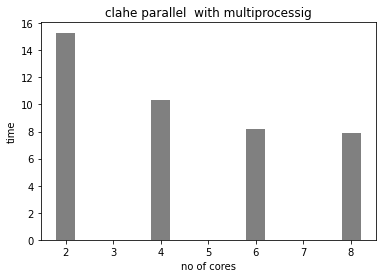

In [20]:
import numpy as np
import matplotlib.pyplot as plt
lst=[15.304189920425415,10.314742088317871,8.202890872955322,7.860849857330322]
n_of_c=[2,4,6,8]
plt.bar(n_of_c,lst, color ='gray',
        width = 0.4)
 
plt.xlabel("no of cores")
plt.ylabel("time")
plt.title("clahe parallel  with multiprocessig")
plt.show()

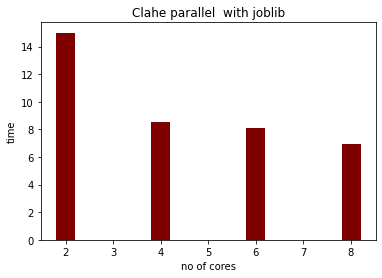

In [13]:
import numpy as np
import matplotlib.pyplot as plt
lst=[15.009116172790527,8.518135070800781,8.080245018005371,6.978994131088257]
n_of_c=[2,4,6,8]
plt.bar(n_of_c,lst, color ='maroon',
        width = 0.4)
 
plt.xlabel("no of cores")
plt.ylabel("time")
plt.title("Clahe parallel  with joblib")
plt.show()